In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import sys

import torch

from time import time


from matplotlib          import rcParams, rc
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 10})
rc('font', family='serif')
rc('text', usetex=True)
# plt.rcParams['figure.dpi'] = 150

## import own functions
sys.path.insert(1, '/STER/silkem/MACE/src/mace')

import src.mace.CSE_0D.dataset  as ds
import train                    as train
import test                     as test
import load                     as load
import src.mace.mace            as mace
from loss                       import Loss
import src.mace.utils           as utils
# from src.mace.neuralODE    import Solver

def temp(Tstar, eps, r):
    Rstar = 2e13
    # r = 1e16
    T = Tstar * (r/Rstar)**(-eps)
    return T



dt_fracts = {4 : 0.296, 5: 0.269,8: 0.221,10: 0.175,12: 0.146,16: 0.117,20: 0.09,25: 0.078,32: 0.062,48: 0.043,64: 0.033,128: 0.017}


%reload_ext autoreload
%autoreload 2

## Training

### Setup hyperparameters for mace model

In [20]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} 

batch_size = 1
nb_test = 300
n_dim = 468

losstype = 'abs_idn_grd'
z_dim = 8
nb_samples = 100
nb_hidden = 1
ae_type = 'simple'
nb_evol = 4


print('------------------------------')
print('# z dimensions:', z_dim)
print('     # samples:', nb_samples)
print('     loss type:', losstype)
print('')


traindata, testdata, data_loader, test_loader = ds.get_data(dt_fract=dt_fracts[z_dim],nb_samples=nb_samples,nb_test = nb_test, batch_size=batch_size, kwargs=kwargs)

------------------------------
# z dimensions: 8
     # samples: 100
     loss type: abs_idn_grd

Dataset:
------------------------------
  total # of samples: 100
#   training samples: 70
# validation samples: 30
               ratio: 0.3
     #  test samples: 300


### Local MACE training


The model has 284692 trainable parameters

Model:         
--------------
     # epochs: 2
learning rate: 1e-05
    loss type: abs_idn_grd

Local training scheme in use.

>>> Training model...


Epoch 1 complete! 	Average loss train:  15.83107 	Average loss test:  6.62382
              time [secs]:  7.86248
Epoch 2 complete! 	Average loss train:  14.90794 	Average loss test:  6.11514
              time [secs]:  14.26791

 	DONE!

 >>> Plotting...


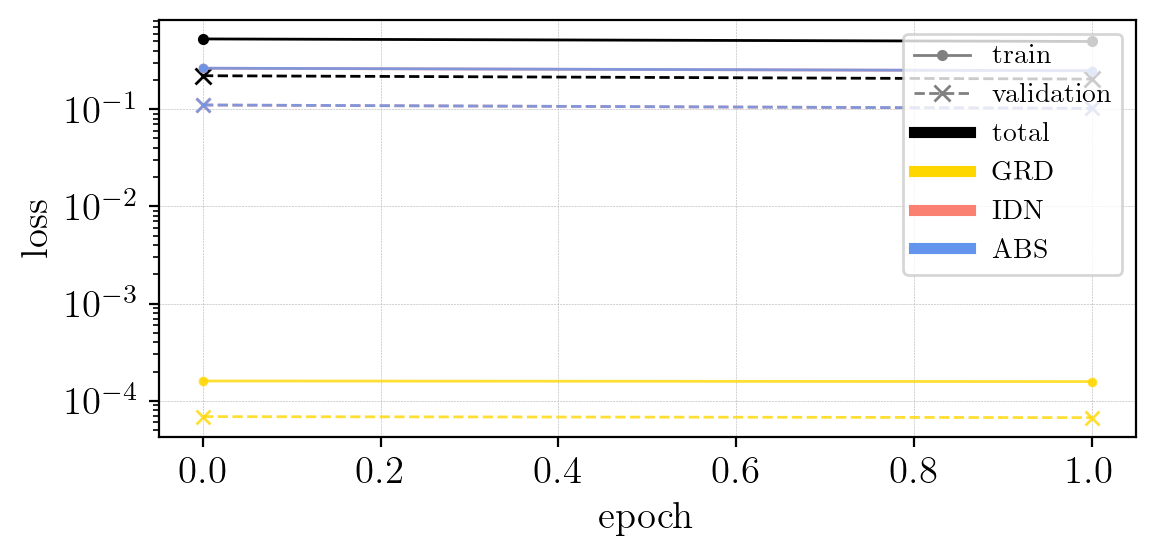

Total time [s]: 15.369702339172363


In [39]:
## Local model

scheme = 'loc'

model = mace.Solver(scheme=scheme,p_dim=4,z_dim = z_dim, n_dim=n_dim,nb_hidden=nb_hidden, ae_type=ae_type, DEVICE = DEVICE, nb_evol=nb_evol)

num_params = utils.count_parameters(model)
print(f'The model has {num_params} trainable parameters\n')


norm = {'abs' : 1,
        'grd' : 1,
        'idn' : 1,
        'elm' : 1}

fract = {'abs' : 1,
         'grd' : 1,
         'idn' : 1, 
         'elm' : 1}

lr = 1.e-5
epochs = 2
plot = True


meta = {  'nb_samples'  : nb_samples,
            'lr'        : lr,
            'epochs'    : epochs,
            'z_dim'     : z_dim,
            'losstype'  : losstype,
            'nb_evol'   : nb_evol,
            'nb_hidden' : nb_hidden,
            'ae_type'   : ae_type,
            'dt_fract'  : dt_fracts[z_dim],
            'nb_test'   : nb_test,
            'done'      : 'false',
}


## Make loss objects
trainloss = Loss(norm, fract, losstype)
testloss  = Loss(norm, fract, losstype)


tic = time()
opt = train.train(model, lr, data_loader, test_loader, path = None, end_epochs = epochs, DEVICE= DEVICE, trainloss=trainloss, testloss=testloss, start_time = time(), plot=plot)
toc = time()

print('Total time [s]:',toc-tic)




In [34]:
trainloss.get_all_losses()

{'tot': array([0.51577465, 0.48494834, 0.43678326, 0.3691519 , 0.29492312]),
 'abs': array([0.25804752, 0.24262139, 0.21852355, 0.18468247, 0.14752409]),
 'grd': array([0.0001601 , 0.0001573 , 0.00015211, 0.00015227, 0.00016682]),
 'idn': array([0.25756702, 0.24216966, 0.2181076 , 0.18431716, 0.14723221]),
 'elm': array([0., 0., 0., 0., 0.])}

{'nb_samples': 100, 'lr': 1e-05, 'epochs': 2, 'z_dim': 8, 'losstype': 'abs_idn_grd', 'nb_evol': 4, 'nb_hidden': 1, 'ae_type': 'simple', 'dt_fract': 0.221, 'nb_test': 300, 'done': 'false'}
>>> Testing step...
Solving time [s]: 0.014052152633666992

>>> Testing evolution...


100%|██████████| 133/133 [00:01<00:00, 101.82it/s]


Solving time [s]: 1.2869319915771484
Total   time [s]: 1.3261139392852783


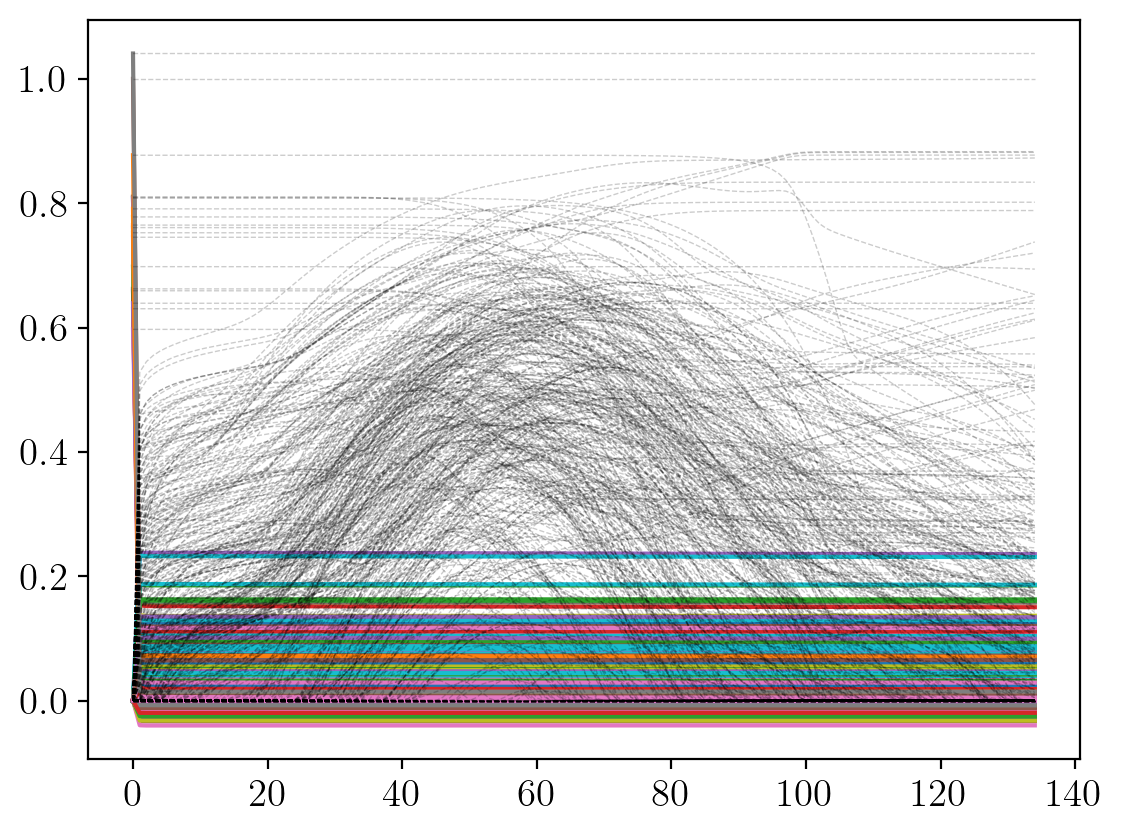

In [41]:
testpath = testdata.testpath[5]
# print(testpath)

# print('>> Loading test data...')
CSEmod, input_data, info = ds.get_test_data(testpath,meta)

n, n_hat, dt, mace_time = test.test_step(model, input_data)
n_evol, mace_evol_time = test.test_evolution(model, input_data, start_idx=0)

plt.plot(n_hat)
plt.plot(input_data[0], 'k--', alpha = 0.2, lw = 0.5)


plt.show()

### Integrated MACE training


The model has 284692 trainable parameters

Model:         
learning rate: 1e-05
loss type:     abs_idn

Integrated training scheme in use.

>>> Training model...
Epoch 1 complete! 	Average loss train:  15.92871 	Average loss test:  6.68934
              time [hours]:  0.00304
Epoch 2 complete! 	Average loss train:  15.15424 	Average loss test:  6.27801
              time [hours]:  0.00696

 	DONE!

 >>> Plotting...


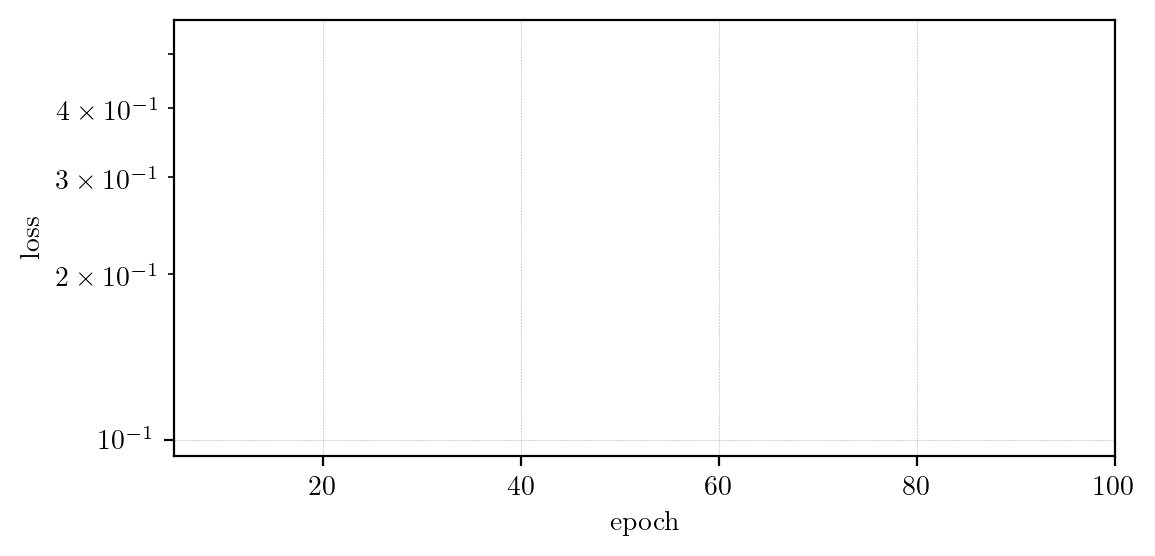

Total time [s]: 26.493305206298828


In [6]:
## Integrated model

model_integr = mace.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim,nb_hidden=nb_hidden, ae_type=ae_type, DEVICE = DEVICE)

num_params = utils.count_parameters(model)
print(f'The model has {num_params} trainable parameters\n')


norm = {'abs' : 1,
        'grd' : 1,
        'idn' : 1}

fract = {'abs' : 1,
         'grd' : 1,
         'idn' : 1}

plot = True
nb_evol = 8


## Make loss objects
trainloss_integr = Loss(norm, fract, losstype)
testloss_integr  = Loss(norm, fract, losstype)


tic = time()
opt = train.train(model_integr, lr, data_loader, test_loader, nb_evol=nb_evol, path = None, end_epochs = epochs, DEVICE= DEVICE, trainloss=trainloss_integr, testloss=testloss_integr, start_time = time(), plot=plot)
toc = time()

print('Total time [s]:',toc-tic)




>>> Testing model...
Solving time [s]: 0.008478879928588867

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 163.10it/s]


Solving time [s]: 0.8115999698638916
Total   time [s]: 0.8256852626800537


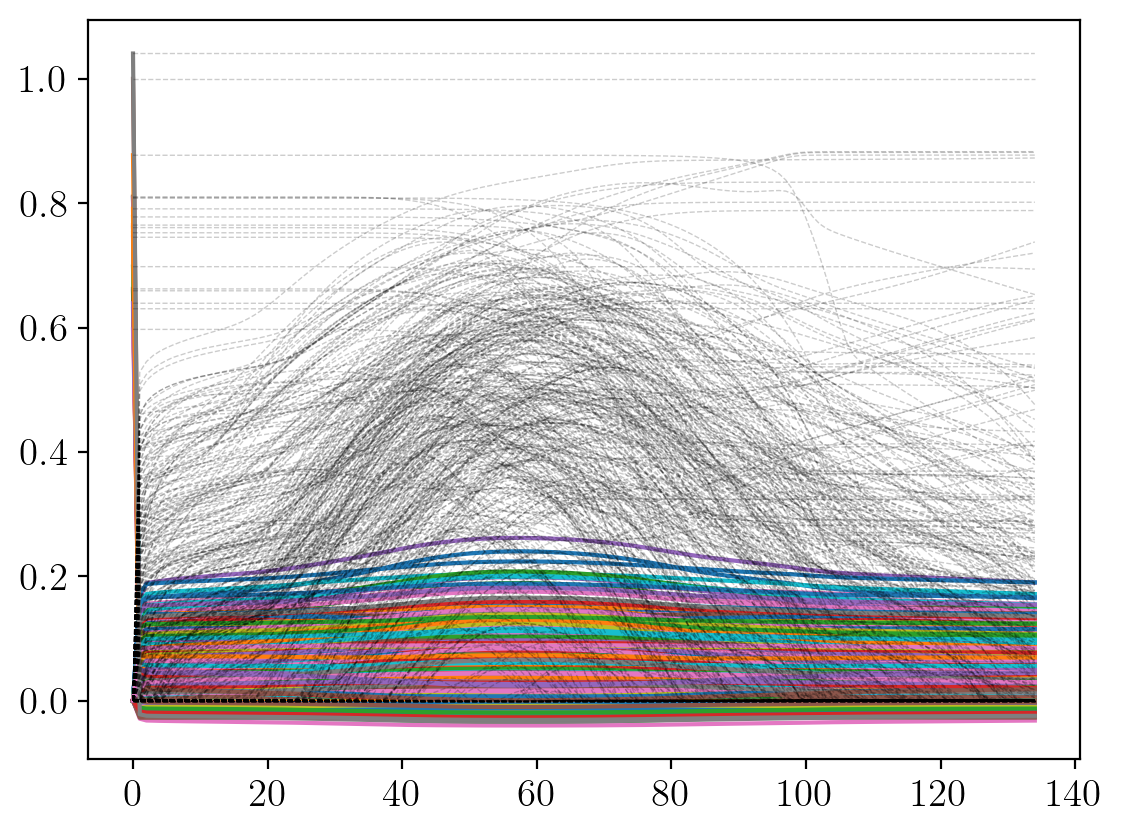

In [7]:
testpath = testdata.testpath[5]

model = model_integr

# print('>> Loading test data...')
input_data, info = ds.get_test_data(testpath,testdata)

n, n_hat, dt, mace_time = test.test_step(model, input_data)
n_evol, mace_evol_time = test.test_evolution(model, input_data, start_idx=0)

plt.plot(n_hat)
plt.plot(input_data[0], 'k--', alpha = 0.2, lw = 0.5)


plt.show()

## Loading MACE models

In [8]:
outloc  = '/STER/silkem/MACE/models/CSE_0D/'
dirname = '20240207_134859_66656_4'

trained = load.Trained_MACE(outloc=outloc, dirname=dirname)

The model has 284692 trainable parameters


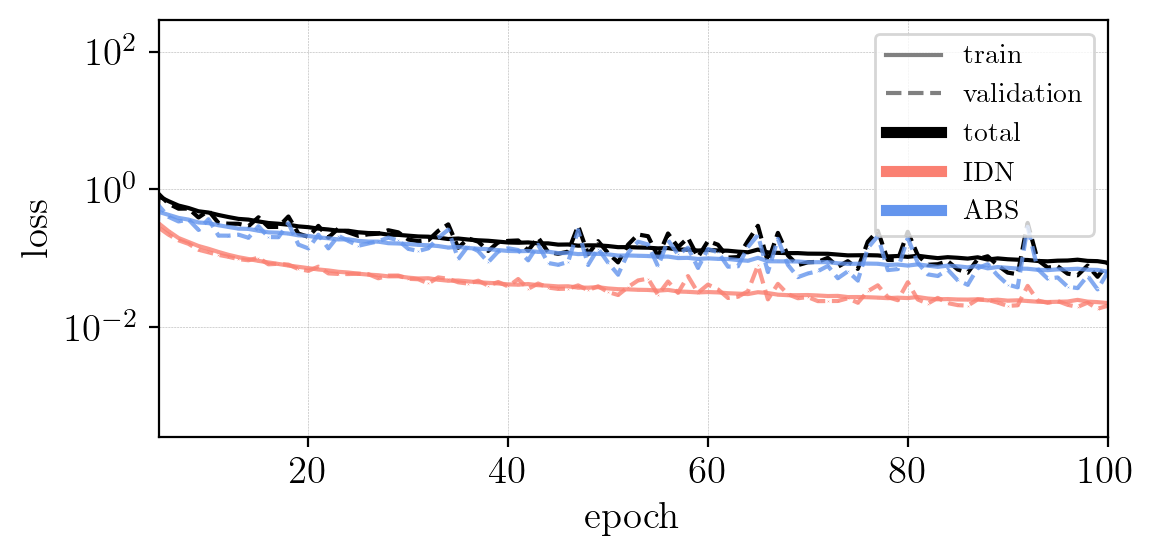

In [32]:
trained.plot_loss(save=False)

>>> Testing step...
Solving time [s]: 0.013584136962890625

>>> Testing evolution...


100%|██████████| 133/133 [00:00<00:00, 171.64it/s]


Solving time [s]: 0.7733039855957031
Total   time [s]: 0.7871415615081787

>>> Denormalising... 

>>> Errors:
     Step      error: 4.719
     Evolution error: 6.968

>>> Plotting...


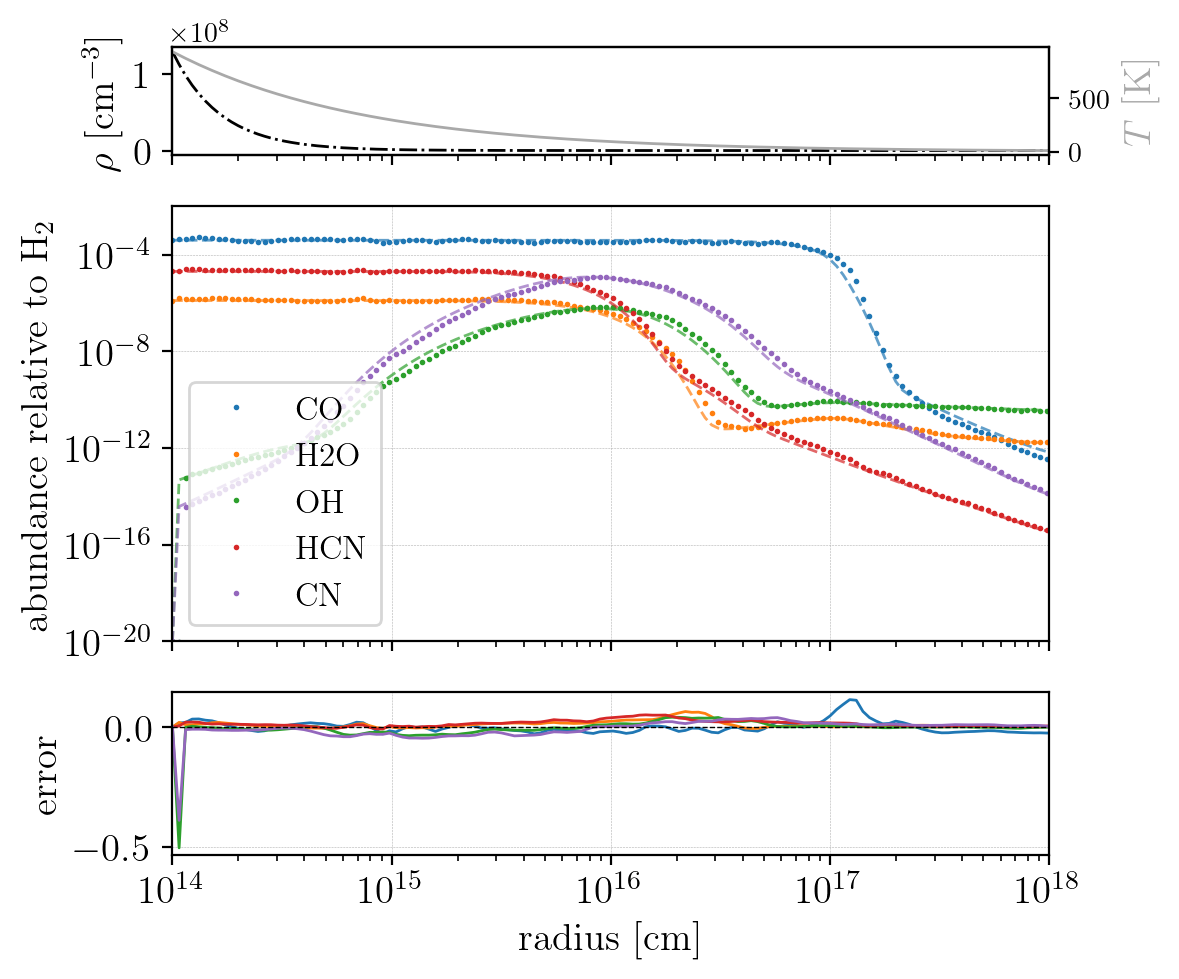

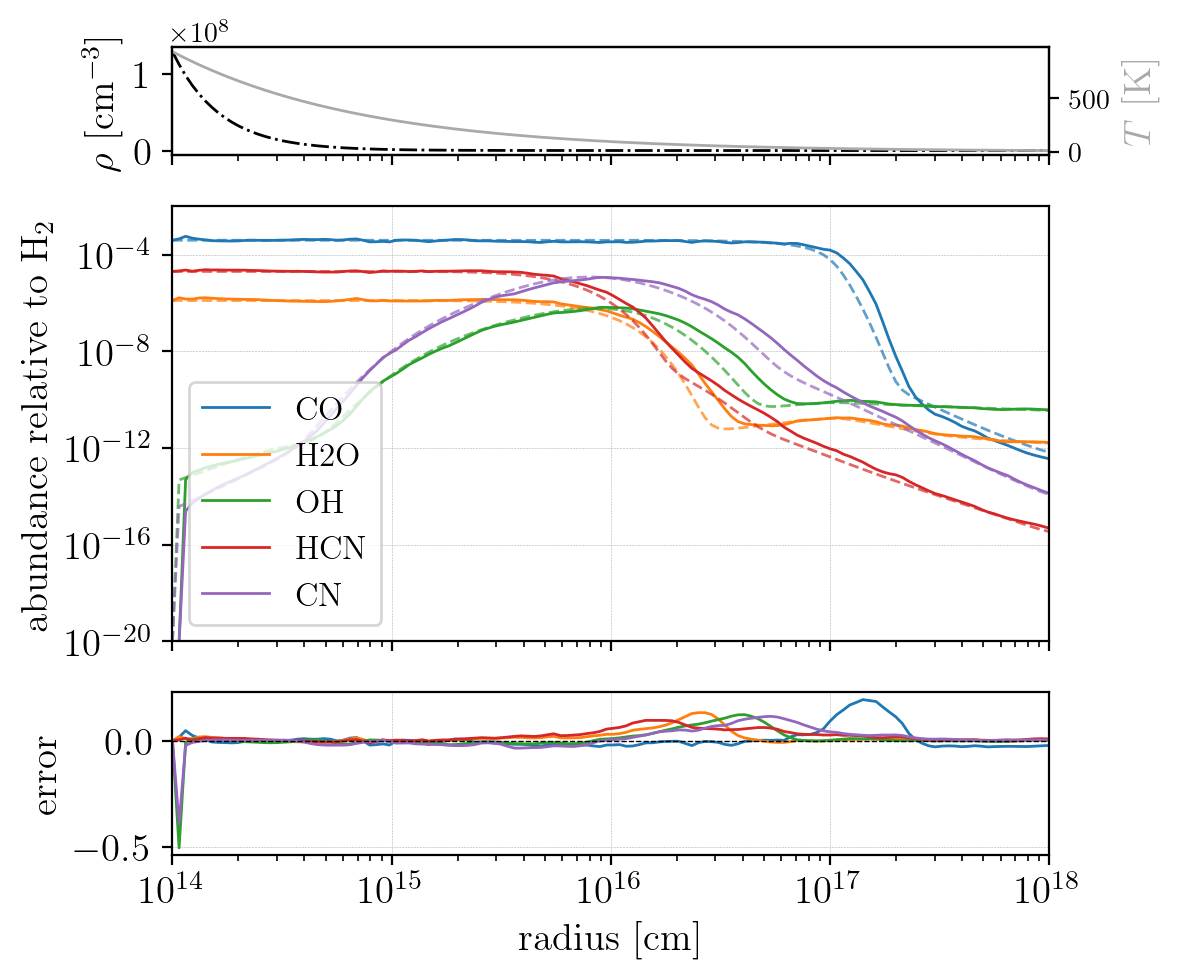

In [9]:
testpath = '/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-6_v17-5_T_eps/models/model_2022-12-24h17-06-51/csfrac_smooth.out'
specs = ['CO', 'H2O', 'OH', 'HCN', 'CN']
# specs = []
# print(len(specs))

macetime = trained.test(testpath, specs, plotting=True)

## Random testing


In [6]:
utils.get_specs()

({'H': 0,
  'H+': 1,
  'H-': 2,
  'H2+': 3,
  'H3+': 4,
  'He': 5,
  'He+': 6,
  'HeH+': 7,
  'C-': 8,
  'C+': 9,
  'C': 10,
  'CH-': 11,
  'CH+': 12,
  'CH': 13,
  'CH2+': 14,
  'N+': 15,
  'CH2': 16,
  'N': 17,
  'CH3': 18,
  'NH': 19,
  'NH+': 20,
  'CH3+': 21,
  'O+': 22,
  'NH2+': 23,
  'CH4+': 24,
  'O-': 25,
  'NH2': 26,
  'O': 27,
  'CH4': 28,
  'OH-': 29,
  'OH': 30,
  'OH+': 31,
  'CH5+': 32,
  'NH3+': 33,
  'NH3': 34,
  'NH4+': 35,
  'H2O': 36,
  'H2O+': 37,
  'F': 38,
  'H3O+': 39,
  'F+': 40,
  'HF': 41,
  'HF+': 42,
  'H2F+': 43,
  'Na': 44,
  'Na+': 45,
  'C2-': 46,
  'C2+': 47,
  'Mg': 48,
  'Mg+': 49,
  'C2': 50,
  'C2H-': 51,
  'C2H+': 52,
  'C2H': 53,
  'CN': 54,
  'C2H2': 55,
  'C2H2+': 56,
  'CN-': 57,
  'CN+': 58,
  'HCN': 59,
  'C2H3': 60,
  'C2H3+': 61,
  'HCN+': 62,
  'HNC': 63,
  'N2': 64,
  'C2H4+': 65,
  'Si+': 66,
  'H2CN': 67,
  'H2NC+': 68,
  'N2+': 69,
  'Si': 70,
  'CO': 71,
  'CO+': 72,
  'C2H4': 73,
  'HCNH+': 74,
  'C2H5+': 75,
  'HCO': 76,
  'SiH+':